# Final Report

## Data

In the project, I use data on couples in Austria which comes from several sources:
* Birth registry (1990-2007)
* Divorce / marriage register until 2007
* Wage income data

I completed the project as a part of my Master's Thesis on the effect of the trend of women getting higher levels of education and how it affects the couples' dynamics.

In total, it is a 5% sample (~34k couples). A couple is operationalized as a female and a male who gave birth to the first child (in other words, they are 'linked' by their first child). Therefore, there is no information on a couple's duration since the couple's breakup is not defined. The couple does not imply marriage (in fact, as we will see, more than 40% of the couples are not married, at least, to the other parent).

The **variables** provided to me are:
* Sex
* Age
* Salaries 2 years before the birth
* Education (compulsory school, apprenticeship, middle or high school, university or college)
* Family status (single, married, married to other person, divorced)
* Municipality as the child's birthplace (not used in the analysis, left for the future step
* Year of the child's birth
* Year of marriage if it happened

In the analysis, I did not use the last three variables, which were left for the future iterations.

### Packages

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

### Data Preparation

In [2]:
data = pd.read_csv("microdata.csv")

# Extracting year from date
data['c_birth_year']=pd.to_datetime(data['c_birth_date']).dt.year

# Dropping out variables not used in the analysis
data.drop(columns=['Unnamed: 0', 'c_birth_date', 'marr_date', 'gr_m_community'], inplace=True)

for col in ['gr_m_family_status', 'm_edu4', 'f_edu4', 'edu4_comp']:
    data[col] = pd.Categorical(data[col])

## Exploratory Data Analysis

In [3]:
data.describe()

,m_age_at_birth,f_age_at_birth,m_annual_salary_tm2,f_annual_salary_tm2,c_birth_year
count,32234.000000,30048.000000,32230.000000,30043.000000,32234.000000
mean,26.066110,29.232994,13025.175232,15986.812664,1998.275579
std,5.077912,6.141691,10397.020006,12935.825221,5.205613
min,14.000000,14.000000,0.000000,0.000000,1990.000000
25%,22.000000,25.000000,3929.285095,3766.359985,1994.000000
50%,26.000000,29.000000,12527.424805,15542.679688,1998.000000
75%,29.000000,33.000000,19739.487793,24615.714844,2003.000000
max,46.000000,69.000000,85272.406250,75627.320312,2007.000000


### Counts of categorical variables

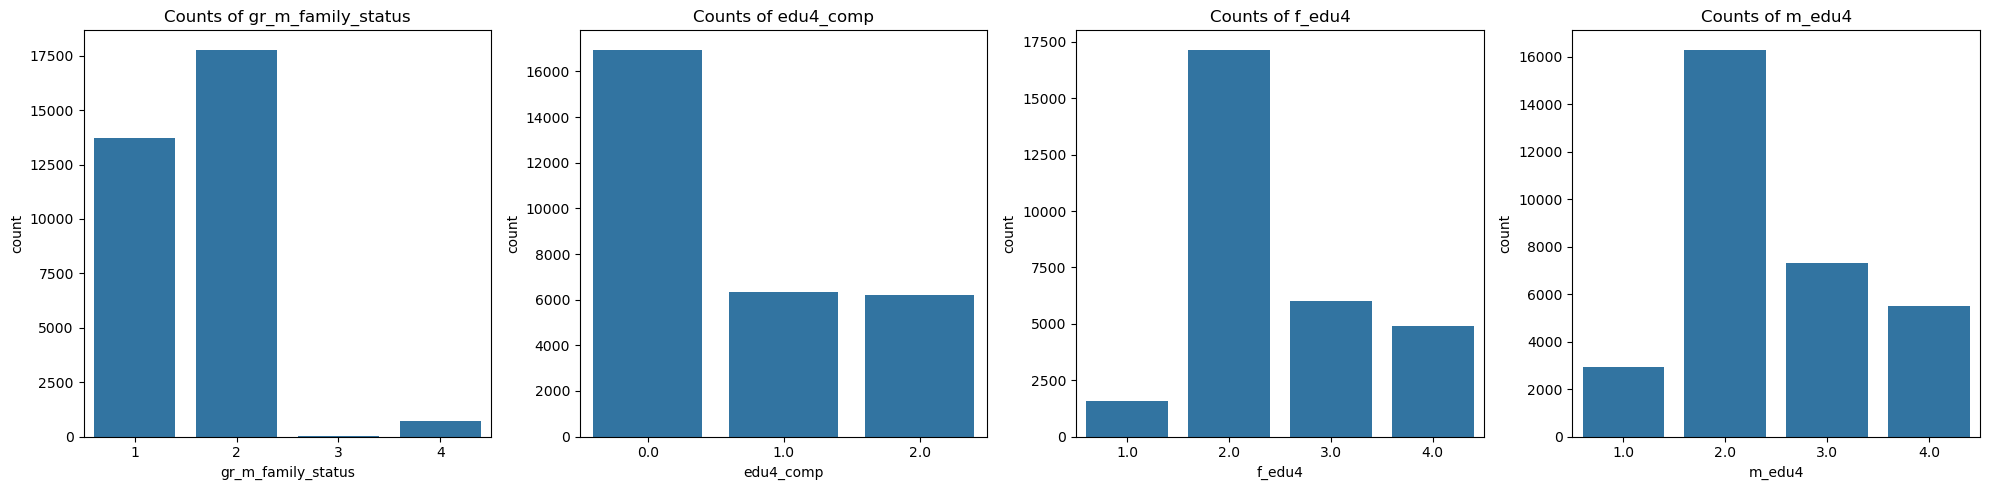

In [5]:
categorical_columns = set()

for column in data:
    if data[column].dtype=='category':
        categorical_columns.add(column)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, data=data, ax=axs[i])
    axs[i].set_title(f'Counts of {column}')

plt.tight_layout()
plt.show()

### Pairwise distributions of continuous variables

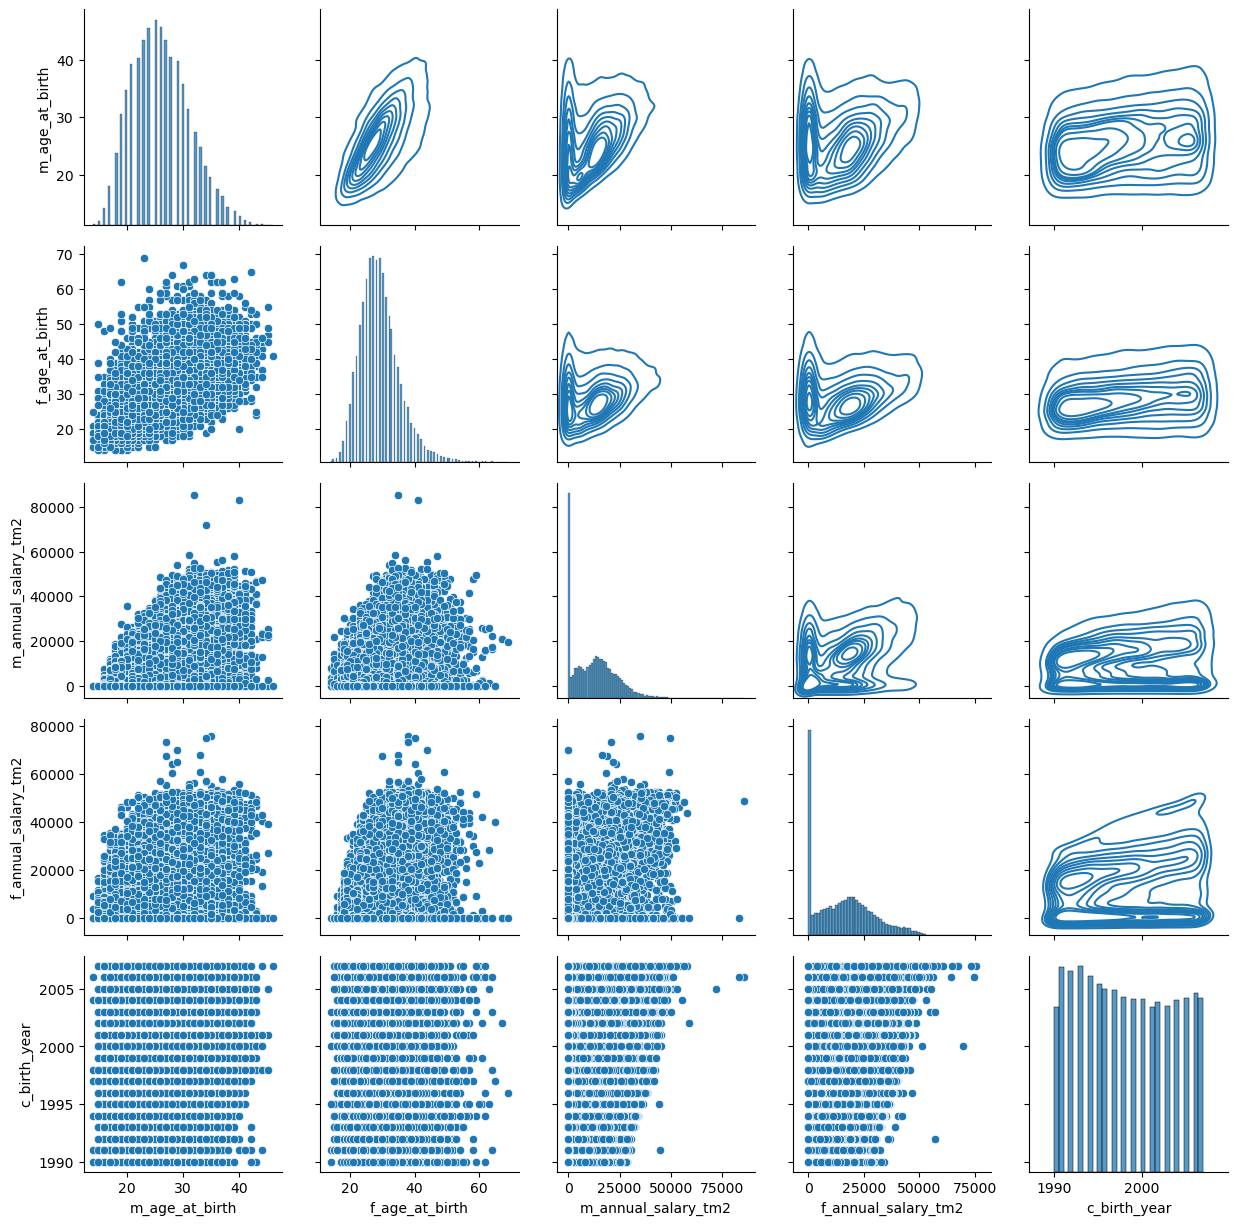

In [6]:
g = sns.PairGrid(data, diag_sharey=False)
g.map_upper(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

## The analysis

### Model A

The model A specifies the relationship between a continuous predictor variable of males' salary and the binary variable of couples' marital status (married / not married).

#### Likelihood
$$
Y_i \sim Bernoulli(p_i)
$$

#### Link function:
$$
\text{logit}(p_i) = \beta_0 + \beta_1 X_i
$$

#### Priors:
$$
\beta_0, \beta_1 \sim \text{Normal}(\mu, \sigma^2)
$$

### Preparing Data
Here, the NAs are omitted, and the family status is refactored to a binary variable.

In [14]:
data_a = data[['m_annual_salary_tm2', 'gr_m_family_status']][data['m_annual_salary_tm2']>0]

data_a.loc[data_a['gr_m_family_status']!=2, 'gr_m_family_status']=1

data_a['gr_m_family_status']=pd.Categorical(data_a['gr_m_family_status'])

In [22]:
model_a = bmb.Model('gr_m_family_status ~ m_annual_salary_tm2',
                   data_a,
                   family="bernoulli")

In [23]:
print(model_a)

       Formula: gr_m_family_status ~ m_annual_salary_tm2
        Family: bernoulli
          Link: p = logit
  Observations: 27073
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.7863)
            m_annual_salary_tm2 ~ Normal(mu: 0.0, sigma: 0.0003)


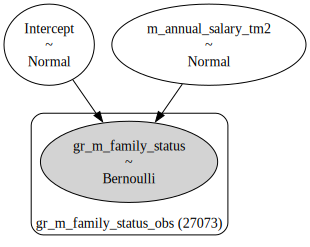

In [33]:
model_b.build()
model_b.graph()

In [26]:
results_b = model_b.fit(draws=1000)

Modeling the probability that gr_m_family_status==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, m_annual_salary_tm2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5416 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [30]:
az.summary(results_b)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2162.168,5594.085,-8823.263,6687.576,2785.832,2133.059,5.0,31.0,2.85
m_annual_salary_tm2,0.139,0.361,-0.431,0.569,0.180,0.138,5.0,31.0,2.85


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'm_annual_salary_tm2'}>,
        <Axes: title={'center': 'm_annual_salary_tm2'}>]], dtype=object)

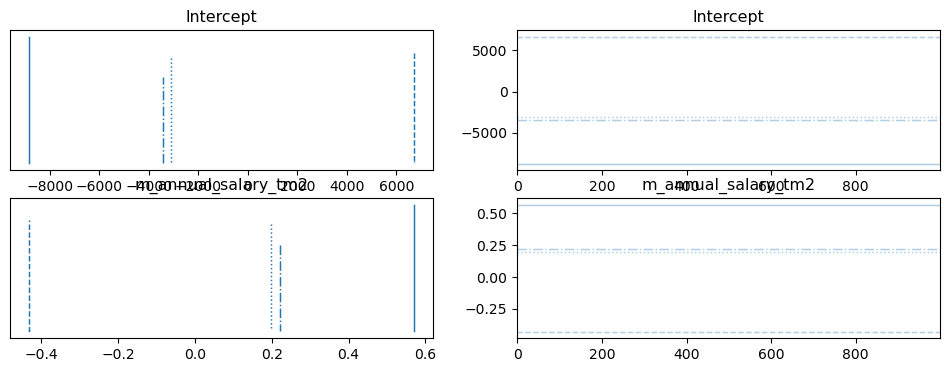

In [31]:
az.plot_trace(results_b)